# CNN - AE model validation

In [1]:
import os
import csv
import random
import umap
import numpy as np
from os import path
from scipy import stats
from sklearn import preprocessing
from sklearn.manifold.t_sne import TSNE
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
%matplotlib inline

### Load data

In [2]:
# data directories
homedir = os.path.expanduser('~')
prjdir = 'data1/stratification_ILRM'
datadir = 'data'
outdir = path.join(homedir, prjdir, datadir, 'ehr100k')
expdir = path.join(homedir, prjdir, datadir, 'experiments/ehr100k-w2v-softplus')

# get the list of diagnosed diseases associated with mrns
with open(path.join(outdir, 'cohort-mrn_diseases.csv')) as f:
    rd = csv.reader(f)
    mrn_disease = {r[0]: r[1::] for r in rd}

with open(path.join(expdir, 'mrns.csv')) as f:
    rd = csv.reader(f)
    mrns = [r[0] for r in rd]
    
# (1) first diagnosis
gt_disease = {}
for m in mrn_disease:
    if mrn_disease[m][0]!='OTH' and m in mrns:
        gt_disease[m] = mrn_disease[m][0]
    else:
        pass

with open(path.join(expdir, 'encoded_vect.csv')) as f:
    rd = csv.reader(f)
    encoded = [list(map(float, r)) for r in rd]

tmp_mrns = []
tmp_encoded = []
for idx, m in enumerate(mrns):
    if m in gt_disease.keys():
        tmp_mrns.append(m)
        tmp_encoded.append(encoded[idx])
    else:
        pass
mrns = tmp_mrns
encoded = tmp_encoded

In [7]:
ric_data = '/home/riccardo/data1/projects/ehr-stratification/data/experiments'
with open(os.path.join(ric_data, 'ehr100k-baseline-dp/mrn.txt')) as f:
    rd = csv.reader(f)
    dp_mrn = []
    for r in rd:
        dp_mrn.append(r[0])
with open(path.join(ric_data, 'ehr100k-baseline-svd/mrn.txt')) as f:
    rd = csv.reader(f)
    svd_mrn = []
    for r in rd:
        svd_mrn.append(r[0])        
dpb = np.load(path.join(ric_data, 'ehr100k-baseline-dp/dp-mxt.npy'))
svdb = np.load(path.join(ric_data, 'ehr100k-baseline-svd/svd-mxt.npy'))

In [8]:
tmp_dp_mrns = []
tmp_dp_encoded = []
for idx, m in enumerate(dp_mrn):
    if m in gt_disease.keys():
        tmp_dp_mrns.append(m)
        tmp_dp_encoded.append(dpb[idx])
    else:
        pass
dp_mrn = tmp_dp_mrns
dpb = tmp_dp_encoded

tmp_svd_mrns = []
tmp_svd_encoded = []
for idx, m in enumerate(svd_mrn):
    if m in gt_disease.keys():
        tmp_svd_mrns.append(m)
        tmp_svd_encoded.append(svdb[idx])
    else:
        pass
svd_mrn = tmp_svd_mrns
svdb = tmp_svd_encoded

In [9]:
# Hierarchical clustering parameters
# Frequency count analysis parameters
ehr_strat_model = False

if ehr_strat_model == True:
    HCpar = {'linkage_clu':'complete',
             'affinity_clu':'cosine',
             'min_cl':2,
             'max_cl':11}
else:
    HCpar = {'linkage_clu':'ward',
             'affinity_clu':'euclidean',
             'min_cl':3,
             'max_cl':4}
FRpar = {'n_terms':0,
        'ty_terms':['']}

In [31]:
# one plot with all the clusters
def single_plot(data, mrn_disease, colors, name_fig, leg_labels=None):
    plt.figure(figsize=(20,10))
    for cl in set(mrn_disease):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j] == cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j] == cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j] == cl]
        plt.xticks([])
        plt.yticks([])
        plt.scatter(x,y,c=cols, label=cl)
    if leg_labels is not None:
        plt.legend(labels=leg_labels, loc=2, fontsize=12, markerscale=2)
    else:
        plt.legend(loc=3, fontsize=12, markerscale=2)
    plt.savefig(path.join(homedir, prjdir, datadir, 
                          'experiments/ehr100k-w2v-softplus/' + name_fig),
               format='eps', dpi=1000)


#Input: ehr lists corresponding to a cluster 
#Output: dictionary of term counts
def FreqDict(tokens):
    freq_dict = {}
    tok = []
    for seq in tokens:
        tok.extend(seq)
    
    tok = set(tok)
    for t in tok:
        for seq in tokens:
            if t in seq:
                if t not in freq_dict:
                    freq_dict[t] = 1
                else:
                    freq_dict[t] += 1
    return freq_dict
#Input: dictionary cluster:ehrs; list mrns
#Output:
def freq_term(data, pred_class):
    list_terms = []
    for subc in range(len(set(pred_class))):
        tmp_data = {}
        for j in range(len(pred_class)):
            if pred_class[j] == subc:
                tmp_data.setdefault(subc, list()).append([rd for rd in data[j] 
                                                           if rd!=0 and 
                                                           (str.split(vocab[str(rd)], "::")[0] 
                                                           in FRpar['ty_terms'])])
        print("Cluster {0} numerosity: {1}".format(subc, len(tmp_data[subc])))
        term_count = FreqDict(tmp_data[subc])
        clust_mostfreq = []
        for l in range(FRpar['n_terms']):
            try:
                MFMT = max(term_count, key=(lambda key: term_count[key]))
                num_MFMT = 0
                subc_termc = 0
                for ehr in tmp_data[subc]:
                    for e in ehr:
                        if e == MFMT:
                            subc_termc += 1
                for seq in raw_ehr.values():
                    for t in seq:
                        if t == MFMT:
                            num_MFMT += 1
                print("% most frequent term:{0} "
                       "= {1:.2f} ({2} out of {3} terms in the whole dataset"
                       "-- N patients in cluster {4})".format(vocab[str(MFMT)], 
                                                              subc_termc/num_MFMT, 
                                                              subc_termc,
                                                              num_MFMT,
                                                              term_count[MFMT]))
                term_count.pop(MFMT)
                clust_mostfreq.append(MFMT)
            except ValueError:
                pass
        print("\n")
        list_terms.append(clust_mostfreq)
    return list_terms

##Hierarchical clustering function. Max silhouette.
def hclust_ehr(data):
    best_silh = -1
    list_silh = []
    for nc in range(HCpar['min_cl'],HCpar['max_cl'],1):
        hclust = AgglomerativeClustering(n_clusters=nc, 
                                         linkage=HCpar['linkage_clu'], 
                                         affinity=HCpar['affinity_clu'])
        tmp_label = hclust.fit_predict(data).tolist()
        tmp_silh = silhouette_score(data, tmp_label, metric=HCpar['affinity_clu'])
        print(nc, tmp_silh)
        list_silh.append(float(tmp_silh))
        if tmp_silh > best_silh:
            best_silh = tmp_silh
            n_clust = nc
            label = tmp_label
    try:
        print("Number of clusters found:{0}, Silhouette score:{1:.3f}\n".format(n_clust, best_silh))
    except UnboundLocalError:
        hclust = AgglomerativeClustering(n_clusters=HCpar['min_cl'],
                                         linkage=HCpar['linkage_clu'],
                                         affinity=HCpar['affinity_clu'])
        n_clust = HCpar['min_cl']
        label = hclust.fit_predict(data).tolist()
        best_silh = silhouette_score(data, label)
        print("Number of clusters found:{0}, Silhouette score:{1:.3f}\n".format(n_clust, best_silh))
    return n_clust, label, list_silh

def chi_test(data, new_classes, term, mrns):
    count_mat = np.zeros((2, len(set(new_classes))), dtype=int)
    for c in set(new_classes):
        for idx, m in enumerate(mrns):
            if new_classes[idx] == c:
                if term in data[idx]:
                    count_mat[1][c] += 1
                else:
                    count_mat[0][c] += 1
    print("Count matrix:\n {0}".format(count_mat))
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(count_mat)
    string = "Chi-squared test statistics: chi2_stat = {0} -- p_val = {1} -- dof = {2}".format(
                                                                  chi2_stat,
                                                                  p_val,
                                                                  dof)#row = classes, columns = vocab
    print(string)
    
##Internal clustering validation
def inner_clustering_analysis(disease_class, data, mrns, viz_data, preproc=False):
    if preproc:
        data = preprocessing.scale(data)
    dis_viz_data = []
    subclass_dis = []
    for dis in sorted(set(disease_class)):
        tmp_data = []
        tmp_mrn = []
        tmp_raw_ehr = []
        for idx, d in enumerate(disease_class):
            if d == dis:
                dis_viz_data.append(viz_data[idx])
                tmp_data.append(data[idx])
                tmp_mrn.append(mrns[idx])
                tmp_raw_ehr.append(raw_ehr[mrns[idx]])
        print("Inspecting disease: {0}\n".format(dis))
        n_clust, label, _ = hclust_ehr(tmp_data)
        subclass_dis.extend([dis + ': subclust ' + str(l) for l in label])
        list_terms = freq_term(tmp_raw_ehr, label)
        for l in range(len(set(label))):
            for lt in range(len(list_terms[l])):
                print("Odds ratio chi2 test for cluster {0}"
                      "term: {1}".format(l, vocab[str(list_terms[l][lt])]))
                try:
                    chi_test(tmp_raw_ehr, label, list_terms[l][lt], tmp_mrn)
                except ValueError:
                    print("empty class(es)")
                    pass
            print("\n\n")
    return(dis_viz_data, subclass_dis)

## Run t-SNE for data visualization

In [11]:
# initialize T-SNE
reducer = umap.UMAP(n_neighbors=200, min_dist=0.5, metric = HCpar['affinity_clu'], n_components=2)
# tsne = TSNE(n_components=2, n_iter=5000, perplexity=40, random_state=42)

In [12]:
# plot colors
col_dict = matplotlib.colors.CSS4_COLORS
c_out = ['mintcream', 'cornsilk', 'lavenderblush', 'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'powderblue', 'floralwhite', 'ghostwhite',
 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue',
 'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'linen', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
 'peachpuff', 'mistyrose', 'lemonchiffon', 'lightblue', 'seashell', 'white', 'blanchedalmond', 'oldlace', 'moccasin', 'snow', 'darkgray',
 'ivory', 'whitesmoke']
colormap = [c for c in col_dict if c not in c_out]

In [13]:
# # t-SNE on the CNN encoded vectors
# # encoded = preprocessing.scale(encoded)
# encoded_umap = reducer.fit_transform(encoded).tolist()
# # encoded_tsne = tsne.fit_transform(encoded).tolist()

# print('Computed: CNN - AE encoded vectors umap')

In [14]:
# t-SNE on the TF-IDF + SVD matrix
# svd_mat = svd_tfidf(raw_data, len_vocab, n_dimensions = 100)
svd_umap = reducer.fit_transform(svdb).tolist()
# tfidf_tsne = tsne.fit_transform(svd_mat).tolist()
print("Computed: TF-IDF matrix umap")

/data1/users/isotta/stratification_ILRM/myvenv/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Computed: TF-IDF matrix umap


In [15]:
# t-SNE on the TF-IDF + SVD matrix
# svd_mat = svd_tfidf(raw_data, len_vocab, n_dimensions = 100)
dp_umap = reducer.fit_transform(dpb).tolist()
# tfidf_tsne = tsne.fit_transform(svd_mat).tolist()
print("Computed: TF-IDF matrix umap")

Computed: TF-IDF matrix umap


## t-SNE visualization and external clustering validation

In [18]:
# choose the disease classes: first_disease, oth_disease
disease_class_first = [gt_disease[m] for m in mrns]
dp_disease_class_first = [gt_disease[m] for m in dp_mrn]
svd_disease_class_first = [gt_disease[m] for m in svd_mrn]

# lstm_disease_class_first = [gt_disease[m] for m in lstm_mrns]
# disease_dict = {d: i for i, d in enumerate(set(disease_class_first))}
disease_dict = {d: i for i, d in enumerate(['Multiple Myeloma', 'Prostate Cancer', 
                                            'Diabetes', 'Alzheimer\'s disease',
                                            'Parkinson\'s disease',
                                            'Breast Cancer'])}

In [19]:
with open(path.join(outdir, 'cohort-new_ehr.csv')) as f:
    rd = csv.reader(f)
    raw_ehr = {}
    for r in rd:
        if r[0] in mrn_disease.keys():
            raw_ehr.setdefault(r[0], list()).extend(list(map(int, r[1::])))
# read the vocabulary
with open(path.join(outdir, 'cohort-new_vocab.csv')) as f:    
    rd = csv.reader(f)
    next(rd)
    vocab = {r[1]: r[0] for r in rd}
len_vocab = len(vocab)

### CNN - AE encodings

In [20]:
colors_vec = ['b','g','m','darkorange','dimgrey','saddlebrown']

In [ ]:
# encoded_new_disease_dict = {}
# t2d_enc = []
# t2d_subc = []
# for idx, sc in enumerate(en_sub_clust):
#     if 'Diabetes' in sc:
#         t2d_enc.append(encoded_subplots[idx])
#         t2d_subc.append(sc)
# for idx, nd in enumerate(set(t2d_subc)):
#     encoded_new_disease_dict[nd] = idx
# colors_en3 = [colors_vec[encoded_new_disease_dict[n]] for n in t2d_subc]
# single_plot(t2d_enc, t2d_subc, colors_en3)

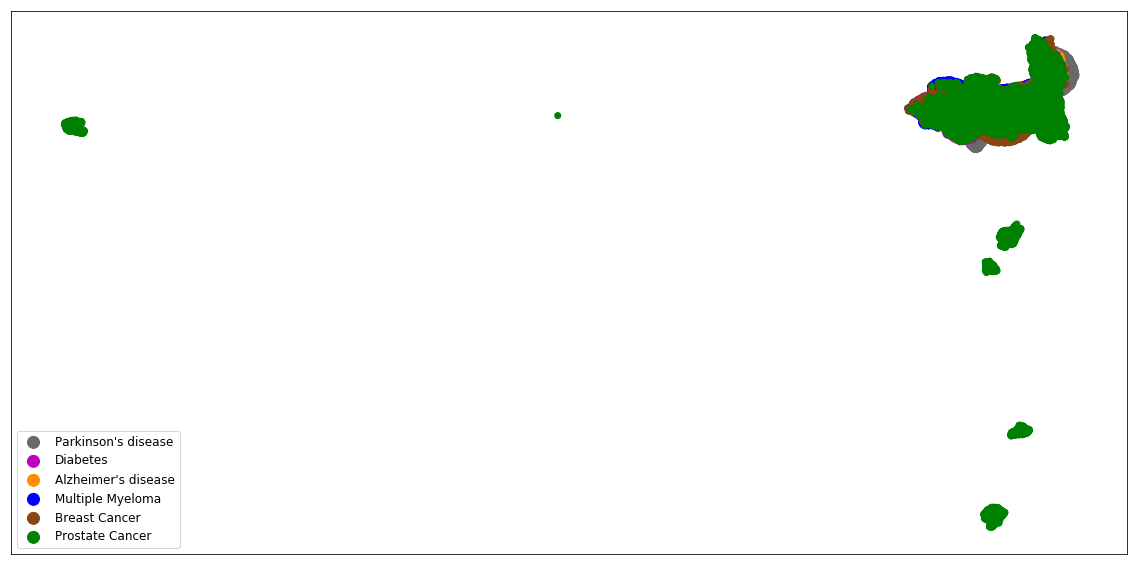

In [32]:
# plot data
colors_dp1 = [colors_vec[disease_dict[v]] for v in dp_disease_class_first]
single_plot(dp_umap, dp_disease_class_first, colors_dp1, name_fig='baseline-dp-plot.eps')

In [21]:
# inner clustering analysis
dp_subplots, dp_sub_clust = inner_clustering_analysis(dp_disease_class_first, dpb, dp_mrn, 
                                                           dp_umap, preproc=True)

/data1/users/isotta/stratification_ILRM/myvenv/lib/python3.5/site-packages/sklearn/preprocessing/data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Inspecting disease: Alzheimer's disease

3 0.2610869138429301
Number of clusters found:3, Silhouette score:0.261

Cluster 0 numerosity: 1659


Cluster 1 numerosity: 1195


Cluster 2 numerosity: 262











Inspecting disease: Breast Cancer

3 0.19851007538491086
Number of clusters found:3, Silhouette score:0.199

Cluster 0 numerosity: 1698


Cluster 1 numerosity: 4818


Cluster 2 numerosity: 3605











Inspecting disease: Diabetes

3 0.3900801139904464
Number of clusters found:3, Silhouette score:0.390

Cluster 0 numerosity: 1745


Cluster 1 numerosity: 1


Cluster 2 numerosity: 459











Inspecting disease: Multiple Myeloma

3 0.3725326725025454
Number of clusters found:3, Silhouette score:0.373

Cluster 0 numerosity: 1225


Cluster 1 numerosity: 1102


Cluster 2 numerosity: 378











Inspecting disease: Parkinson's disease

3 0.421813102332989
Number of clusters found:3, Silhouette score:0.422

Cluster 0 numerosity: 828


Cluster 1 numerosity: 2414


Cluster 2 numer

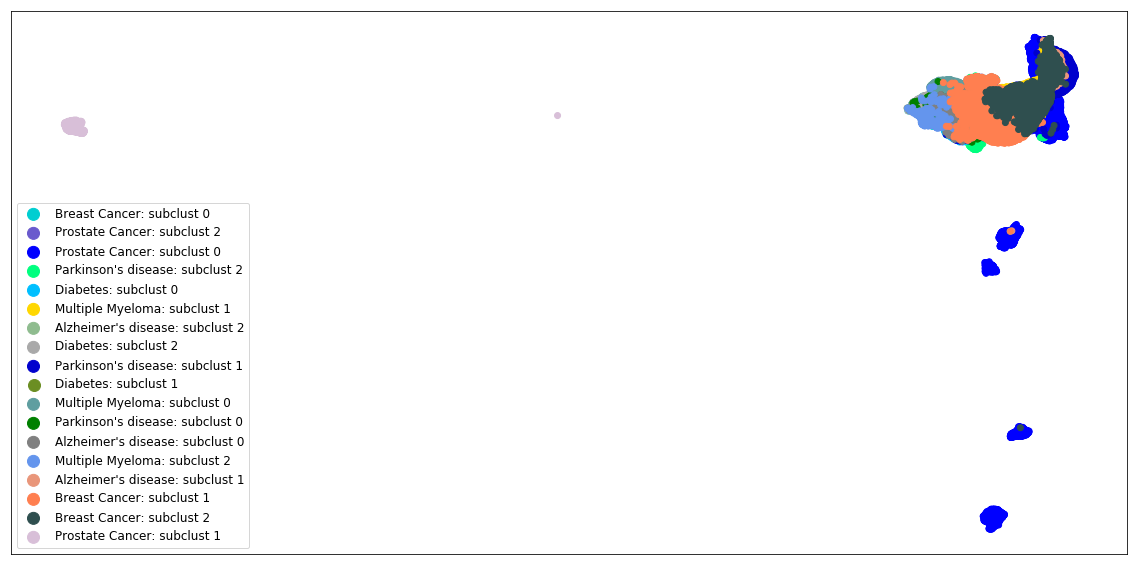

In [33]:
dp_new_disease_dict = {}
for idx, nd in enumerate(set(dp_sub_clust)):
    dp_new_disease_dict[nd] = idx
colors_dp3 = [colormap[dp_new_disease_dict[v]] for v in dp_sub_clust]
single_plot(dp_subplots, dp_sub_clust, colors_dp3, name_fig='baseline-dp-subc.eps')

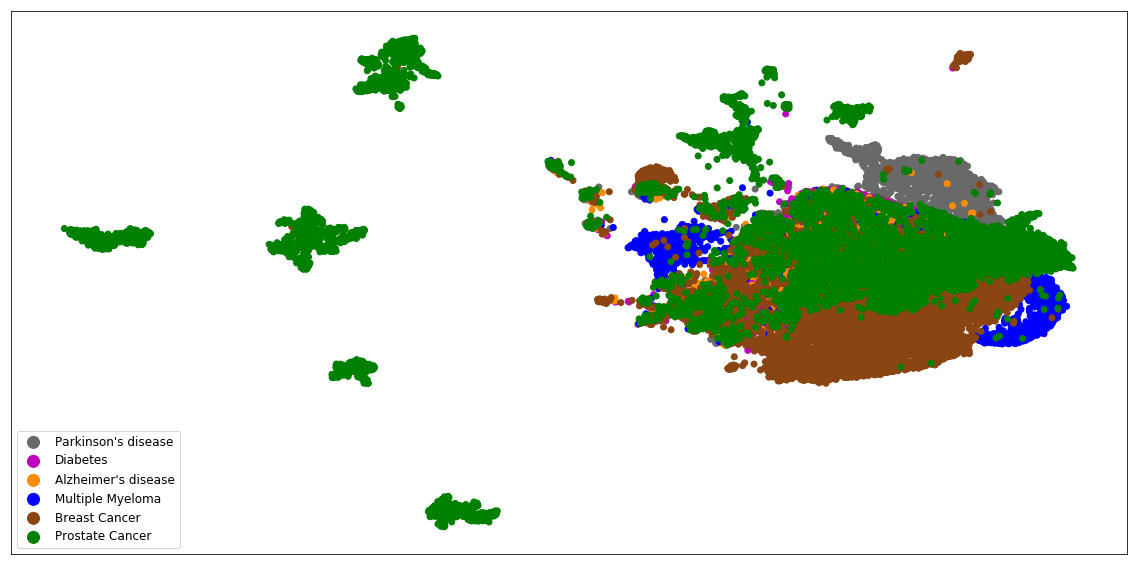

In [34]:
# plot data
colors_svd1 = [colors_vec[disease_dict[v]] for v in svd_disease_class_first]
single_plot(svd_umap, svd_disease_class_first, colors_svd1, name_fig='baseline-svd-plot.eps')

In [27]:
# inner clustering analysis
svd_subplots, svd_sub_clust = inner_clustering_analysis(svd_disease_class_first, svdb, svd_mrn, 
                                                           svd_umap, preproc=True)

Inspecting disease: Alzheimer's disease

3 0.4618274544651518
Number of clusters found:3, Silhouette score:0.462

Cluster 0 numerosity: 135


Cluster 1 numerosity: 2951


Cluster 2 numerosity: 30











Inspecting disease: Breast Cancer

3 0.4604657327826706
Number of clusters found:3, Silhouette score:0.460

Cluster 0 numerosity: 9956


Cluster 1 numerosity: 121


Cluster 2 numerosity: 44











Inspecting disease: Diabetes

3 0.4253242197881239
Number of clusters found:3, Silhouette score:0.425

Cluster 0 numerosity: 2159


Cluster 1 numerosity: 20


Cluster 2 numerosity: 26











Inspecting disease: Multiple Myeloma

3 0.26745642243592394
Number of clusters found:3, Silhouette score:0.267

Cluster 0 numerosity: 593


Cluster 1 numerosity: 213


Cluster 2 numerosity: 1899











Inspecting disease: Parkinson's disease

3 0.4613456095266072
Number of clusters found:3, Silhouette score:0.461

Cluster 0 numerosity: 3618


Cluster 1 numerosity: 139


Cluster 2 numerosity

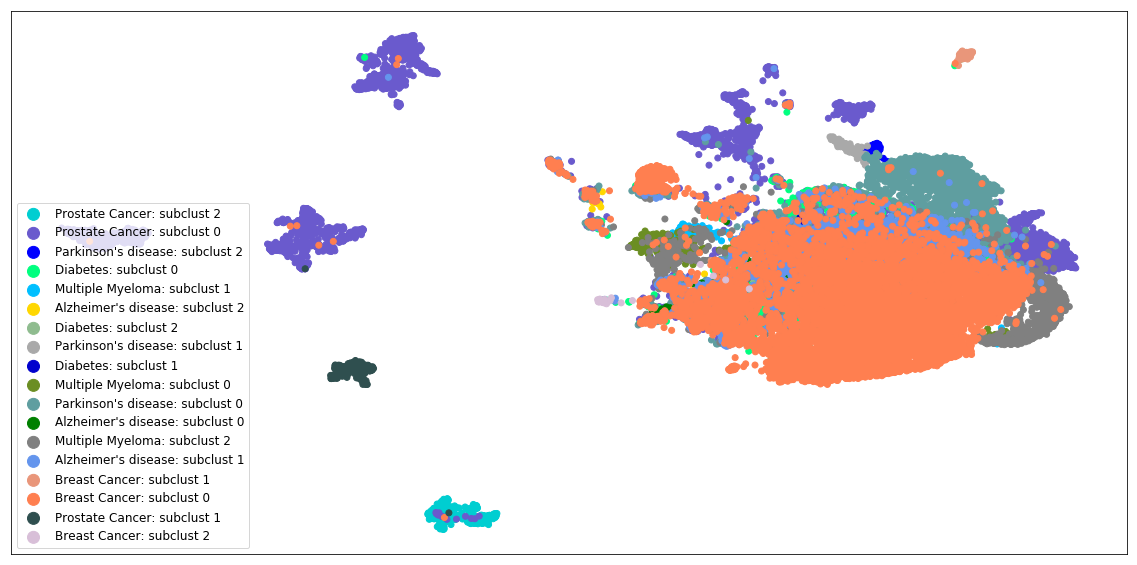

In [35]:
svd_new_disease_dict = {}
for idx, nd in enumerate(set(svd_sub_clust)):
    svd_new_disease_dict[nd] = idx
colors_svd3 = [colormap[svd_new_disease_dict[v]] for v in svd_sub_clust]
single_plot(svd_subplots, svd_sub_clust, colors_svd3, name_fig='baseline-svd-subc.eps')

In [ ]:
colors_mm = ['b', 'g', 'm']
mm_idx = []
mm_enc = []
mm_sub_cl = []
for idx, nwd in enumerate(en_sub_clust):
    if nwd.find('myeloma')!=-1:
        mm_idx.append(idx)
        mm_sub_cl.append(nwd)
        mm_enc.append(encoded_subplots[idx])
encoded_mm_disease_dict = {}
for idx, nd in enumerate(set(mm_sub_cl)):
    encoded_mm_disease_dict[nd] = idx
colors_en3 = [colors_mm[encoded_mm_disease_dict[v]] for v in mm_sub_cl]
single_plot(mm_enc, mm_sub_cl, colors_en3)
plt.savefig(path.join(expdir, 'mm_subclusters.png'))

In [ ]:
nonoverlap_plot(mm_enc, mm_sub_cl, colors_en3)

In [ ]:
colors_en3 = [colormap[encoded_new_disease_dict[v]+2] for v in en_sub_clust]
nonoverlap_plot(encoded_subplots, en_sub_clust, colors_en3)

In [ ]:
# nonoverlap_plot(encoded_subplots, en_sub_clust, colors_en3)

### Raw Counts

In [ ]:
# plot data
# colors_raw1 = [colormap[disease_dict[v]] for v in disease_class_first]
# single_plot(raw_tsne, disease_class_first, colors_raw1)

# plot cluster results
# clusters = outer_clustering_analysis(raw_data_scaled, gt_disease.values())
# colors_raw2 = [colormap[v] for v in clusters]
# single_plot(raw_tsne, clusters, colors_raw2)

### Tfidf matrix

In [ ]:
# plot data
colors_tfidf1 = [colormap[disease_dict[v]] for v in raw_disease_class_first]
single_plot(tfidf_umap, raw_disease_class_first, colors_tfidf1)

In [ ]:
# nonoverlap_plot(tfidf_umap, disease_class_first, colors_en1)

# plot cluster results
clusters = outer_clustering_analysis(svd_mat, raw_disease_class_first)
colors_tfidf2 = [colormap[v] for v in clusters]
single_plot(tfidf_umap, clusters, colors_tfidf2)
for i in range(len(set(clusters))):
    print("Cluster numerosity:{0}".format(clusters.count(i)))

In [ ]:
_,_,_ = silhouette_analysis(svd_mat)

In [ ]:
tfidf_subplots, tfidf_sub_clust = inner_clustering_analysis(raw_disease_class_first, svd_mat, 
                                                            mrn_list, tfidf_umap)

tfidf_new_disease_dict = {}
for idx, nd in enumerate(set(tfidf_sub_clust)):
    tfidf_new_disease_dict[nd] = idx
colors_count3 = [colormap[tfidf_new_disease_dict[v]] for v in tfidf_sub_clust]
single_plot(tfidf_subplots, tfidf_sub_clust, colors_count3)

## LSTM encodings

In [ ]:
# plot data
colors_lstm1 = [colormap[disease_dict[v]] for v in lstm_disease_class_first]
single_plot(lstm_encoded_umap, lstm_disease_class_first, colors_lstm1)

In [ ]:
# plot cluster results
clusters = outer_clustering_analysis(lstm_encoded_vect, lstm_disease_class_first)
colors_lstm2 = [colormap[v] for v in clusters]
single_plot(lstm_encoded_umap, clusters, colors_lstm2)

In [ ]:
lstm_subplots, lstm_sub_clust = inner_clustering_analysis(lstm_disease_class_first, lstm_encoded_vect, 
                                                          lstm_mrns, lstm_encoded_umap)

lstm_new_disease_dict = {}
for idx, nd in enumerate(set(lstm_sub_clust)):
    lstm_new_disease_dict[nd] = idx
colors_lstm3 = [colormap[lstm_new_disease_dict[v]] for v in lstm_sub_clust]
single_plot(lstm_subplots, lstm_sub_clust, colors_lstm3)

## Results
```mixed-nobn-act-relu-10-overlap5-l32```

__Outer analysis (scaled)__

```
Cluster: 0 -- Entropy: 2.346, Purity: 0.341
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 1 -- Entropy: 2.087, Purity: 0.382
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 2 -- Entropy: 1.662, Purity: 0.527
max(P) in cluster disease OTH
Cluster: 3 -- Entropy: 0.347, Purity: 0.953
max(P) in cluster disease multiple myeloma
Cluster: 4 -- Entropy: 1.719, Purity: 0.408
max(P) in cluster disease parkinson's disease
Cluster: 5 -- Entropy: 0.826, Purity: 0.839
max(P) in cluster disease malignant tumor of prostate
Average Entropy: 1.85
Average Purity: 0.48
```

__Inner analysis (scaled)__

```
OTH -- 2 -- 0.199
Alzheimer's -- 2 -- 0.254
Breast Cancer -- 2 -- 0.205
Prostate Cancer -- 3 -- 0.090
MM -- 2 -- 0.182
Parkinson -- 2 -- 0.262
```

```mixed-icdmed-nobn-noact-norelu-10-overlap5-l64```

__Outer analysis (scaled)__

```
Cluster: 0 -- Entropy: 2.257, Purity: 0.323
max(P) in cluster disease alzheimer's disease
Cluster: 1 -- Entropy: 2.197, Purity: 0.407
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 2 -- Entropy: 0.280, Purity: 0.963
max(P) in cluster disease malignant tumor of prostate
Cluster: 3 -- Entropy: 1.935, Purity: 0.343
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 4 -- Entropy: 0.479, Purity: 0.929
max(P) in cluster disease OTH
Cluster: 5 -- Entropy: 1.460, Purity: 0.525
max(P) in cluster disease multiple myeloma
Average Entropy: 1.75
Average Purity: 0.50
```

__Inner analysis (scaled)__

```
OTH -- 3 -- 0.108
Alzheimer's -- 3 -- 0.126
Breast Cancer -- 2 -- 0.111
Prostate Cancer -- 5 -- 0.125
MM -- 2 -- 0.175
Parkinson -- 2 -- 0.119
```

```mixed-nobn-noact-norelu-10-overlap5-l32```

__Outer analysis (scaled)__

```
Cluster: 0 -- Entropy: 2.388, Purity: 0.257
max(P) in cluster disease OTH
Cluster: 1 -- Entropy: 2.390, Purity: 0.317
max(P) in cluster disease OTH
Cluster: 2 -- Entropy: 1.628, Purity: 0.519
max(P) in cluster disease OTH
Cluster: 3 -- Entropy: 0.170, Purity: 0.979
max(P) in cluster disease malignant tumor of prostate
Cluster: 4 -- Entropy: 0.430, Purity: 0.938
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 5 -- Entropy: 0.191, Purity: 0.976
max(P) in cluster disease multiple myeloma
Average Entropy: 1.77
Average Purity: 0.48
```

__Inner analysis (scaled)__

```
OTH -- 2 -- 0.097
Alzheimer's -- 2 -- 0.153
Breast Cancer -- 4 -- 0.108
Prostate Cancer -- 3 -- 0.105
MM -- 2 -- 0.217
Parkinson -- 2 -- 0.211
```

```mixed-icdmed-2019-03-08-10-35-14-median-nobn-noact-norelu-10-l64```

__Outer analysis (scaled)__

```
Cluster: 0 -- Entropy: 1.655, Purity: 0.460
max(P) in cluster disease parkinson's disease
Cluster: 1 -- Entropy: 2.436, Purity: 0.260
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 2 -- Entropy: 0.727, Purity: 0.859
max(P) in cluster disease OTH
Cluster: 3 -- Entropy: 1.753, Purity: 0.394
max(P) in cluster disease malignant tumor of prostate
Cluster: 4 -- Entropy: 0.267, Purity: 0.967
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 5 -- Entropy: 1.446, Purity: 0.638
max(P) in cluster disease malignant tumor of prostate
Average Entropy: 1.77
Average Purity: 0.47
```

__Inner analysis (scaled)__

```
OTH -- 2 -- 0.121
Alzheimer's -- 2 -- 0.105 
Breast Cancer -- 3 -- 0.095
Prostate Cancer -- 3 -- 0.116
MM -- 5 -- 0.139
Parkinson -- 2 -- 0.147 
```